# Import các thư viện cần thiết

In [105]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib.ticker as ticker
import numpy as np
import pyodbc

# Xây dựng pandas dataframe

In [118]:
# Xác định sản phẩm muốn lấy giá
TICKERS = "GC=F"

# Xác định khung thời gian
START_DATE = "2000-12-31"
#end_date = pd.to_datetime(dt.now()).strftime('%Y-%m-%d')
END_DATE = "2024-01-01"

# Download giá vàng trong khung thời gian
gold_data = pd.DataFrame(yf.download(tickers = TICKERS, start=START_DATE, end=END_DATE))

[*********************100%***********************]  1 of 1 completed


# Xuất dữ liệu ra file csv để import vào database

In [120]:
my_csv = gold_data.reset_index().to_csv(r"D:\03.PYTHON\Python ứng dụng\gold_price.csv", index=False)

In [109]:
# Kết nối vào database
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SELEN;'
                      'Database=Gold_predict;'
                      'Trusted_Connection=yes;')

# Phân tích dữ liệu

In [111]:
# Tạo pandas dataframe dùng để phân tích bằng cách kết nối vào My SQL Server và query trực tiếp
df = pd.read_sql('SELECT "Date" as "date", "Open" as "open", "Close" as "close", "Volume" as "volume" FROM gold_price' ,conn)

# Định dạng cột "date" theo đúng định dạng ngày của Pandas
df['date'] = pd.to_datetime(df['date'])

# Định dạng cột "date" theo đúng định dạng ngày của Pandas
#df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')



C:\Users\ASUS\AppData\Local\Temp\ipykernel_11400\3435874985.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT "Date" as "date", "Open" as "open", "Close" as "close", "Volume" as "volume" FROM gold_price' ,conn)


In [112]:
# Tạo font dict
label_font = {
    'family': 'sans serif',
    'weight': 'normal',
    'size': 10
}

axis_font = {
    'family': 'sans serif',
    'weight': 'normal',
    'style': 'italic',
    'size': 12
}

title_font = {
    'family': 'cambria',
    'weight': 'heavy',
    'color': 'red',
    'size': 18
}

# Tạo hiệu ứng cho các loại font
pe = patheffects.withSimplePatchShadow(offset = (1.3, -2.65), shadow_rgbFace = '#8fac12', alpha = 0.43)

## Phân tích về khối lượng giao dịch (volumn)

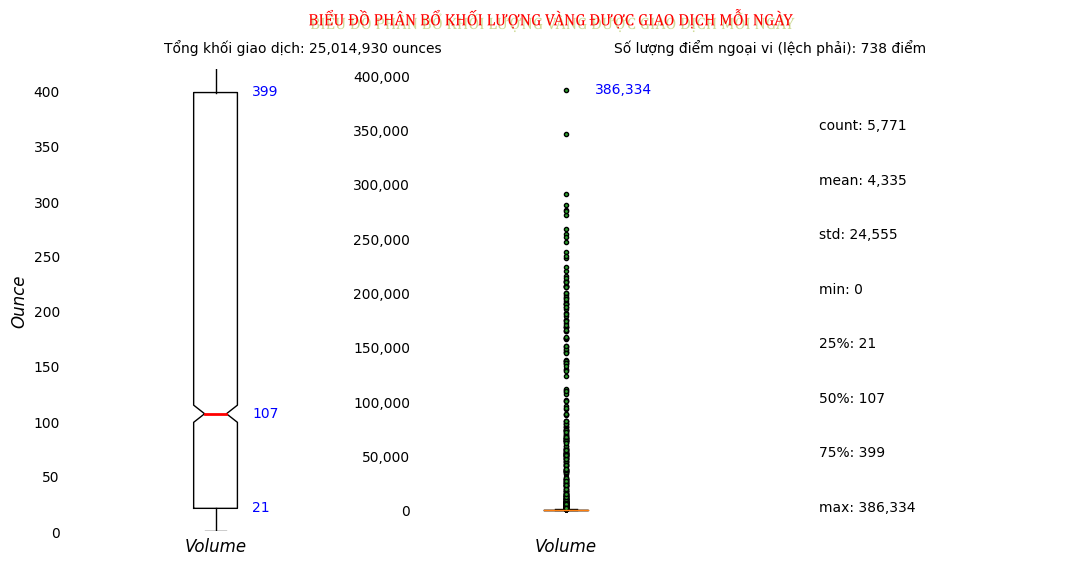

In [113]:
# Tổng khối lượng vàng giao dịch
total_volume = df['volume'].sum()

# Tính toán các điểm phần tư trong box plot
q1 = df['volume'].describe()['25%']
q2 = df['volume'].describe()['50%']
q3 = df['volume'].describe()['75%']

# Tính số lượng điểm ngoại vi
iqr = q3 - q1 # iqr là "Khoảng trải giữa"

outliers = df[(df['volume'] > (q3 + 1.5 * iqr)) | (df['volume'] < (q1 - 1.5 * iqr))]

num_outliers = len(outliers)

# Vẽ chart
#   Vẽ 02 box plot cạnh nhau
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12.8, 6))

#   Box plot phóng to
ax1.boxplot(df['volume'], notch=True, medianprops={'color': 'red', "linewidth": 2})

#   Thêm label là các điểm thuộc các phần tư
for i in [q1, q2, q3]:
    ax1.text(1.125, i-3, f"{i:.0f}", fontdict=label_font, color = "blue")

ax1.text(1.3, 440, f"Tổng khối giao dịch: {total_volume:,.0f} ounces", ha='center', va='center', fontdict=label_font)
ax1.text(2.9, 440, f"Số lượng điểm ngoại vi (lệch phải): {num_outliers} điểm", ha='center', va='center', fontdict=label_font)
ax1.set_ylabel("Ounce", fontdict=axis_font)
ax1.set_xlabel("Volume", fontdict=axis_font) # Đặt tên biến ở trục hoành
ax1.set_ylim(0, 420) # Phóng to đoạn chứa median

#   Bỏ các đường khung
ax1.spines['top'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.spines['bottom'].set_color('none')
ax1.spines['left'].set_color('none')

#   Bỏ các dấu tick trên 2 trục
ax1.tick_params(left=False)
ax1.tick_params(bottom=False, labelbottom=False)

#   Box plot tổng
ax2.boxplot(df['volume'], flierprops={"marker":'.', "markerfacecolor":'C2'})

#   Thêm label vào điểm ngoại vi có giá trị lớn nhất
ax2.text(1.1, max(df['volume'])-3000, f"{max(df['volume']):,.0f}", color = "blue")
ax2.set_xlabel("Volume", fontdict=axis_font)

ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False)
ax2.tick_params(bottom=False, labelbottom = False)

#   Format hiến thị label trên trục tung
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
ax2.yaxis.set_major_formatter(formatter)

#   Thêm biểu đồ thứ 3, liệt kê các chỉ số thống kê
ax3.axis('off')

for i, j in df['volume'].describe().items():
    ax3.text(0.17, 0.87 - 0.118 * list(df['volume'].describe().items()).index((i, j)), f"{i}: {j:,.0f}", fontdict=label_font)

#   Thêm title vào chart
fig.suptitle("BIỂU ĐỒ PHÂN BỔ KHỐI LƯỢNG VÀNG ĐƯỢC GIAO DỊCH MỖI NGÀY", fontdict = title_font).set_path_effects([pe])

plt.show()

## Phân tích giá đóng cửa

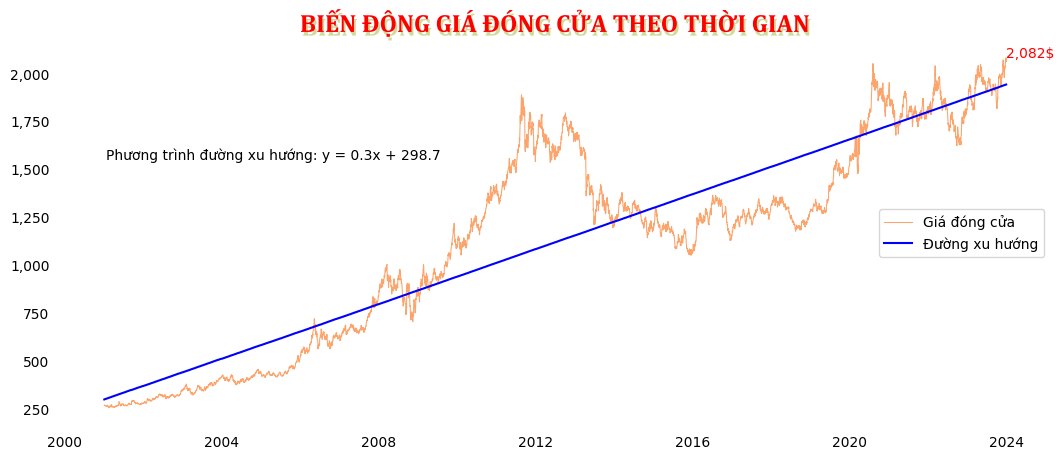

In [121]:
# Vẽ line chart giá đóng cửa "close" theo thời gian
fig, ax = plt.subplots(figsize = (12.8, 5))

close_chart = ax.plot(df['date'], df['close'], linewidth = 0.75, color = "#fca46b", linestyle = "-", label = "Giá đóng cửa")

#   Tính toán và thêm giá đóng cửa lớn nhất vào chart
max_close = df['close'].max()
max_date = df.loc[df['close'] == max_close, 'date'].iloc[0]
ax.annotate(f'{max_close:,.0f}$', xy=(max_date, max_close), xytext=(max_date + pd.Timedelta(days=1), max_close), color = "red")

#   Vẽ đường trend line trên cùng chart với close
x = np.arange(len(df))
y = df['close']
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)
ax.plot(df['date'], trendline(x), linewidth = 1.5, linestyle='-', color="blue", label="Đường xu hướng")

#   Viết phương trình đường xu hướng
a = coefficients[0]
b = coefficients[1]

linear_equation = f"y = {a:.1f}x + {b:.1f}"

ax.text(df['date'].iloc[10], 1550, f"Phương trình đường xu hướng: {linear_equation}", fontdict=label_font)

#   Thêm legend
ax.legend(loc = "center right")

#   Bỏ các đường khung
ax.spines['top'].set_visible(False)
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_color('none')
ax.tick_params(left=False)
ax.tick_params(bottom=False)

#   Thêm title vào chart
ax.set_title("BIẾN ĐỘNG GIÁ ĐÓNG CỬA THEO THỜI GIAN", fontdict=title_font).set_path_effects([pe])

#   Điều chỉnh hiển thị trên trục tung
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
ax.yaxis.set_major_formatter(formatter)

plt.show()

## Phân tích sự chênh lệch giữa giá đóng cửa và giá mở cửa

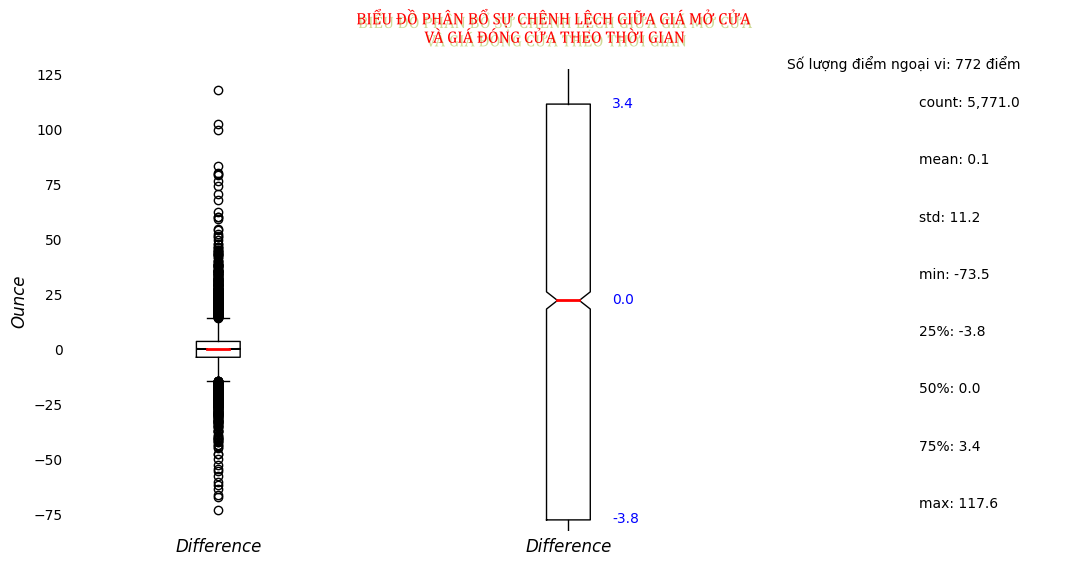

In [122]:
# Tạo cột mới là giá trị chênh lệch giữa giá mở cửa và giá đóng của
df['open_close_diff'] = df['open'] - df['close']

fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize = (12.8, 6))

diff = ax4.boxplot(df['open_close_diff'], notch=True, medianprops={'color': 'red', "linewidth": 2})

ax4.set_ylabel("Ounce", fontdict=axis_font)
ax4.set_xlabel("Difference", fontdict=axis_font) # Đặt tên biến ở trục hoành

#   Bỏ các đường khung
ax4.spines['top'].set_color('none')
ax4.spines['right'].set_color('none')
ax4.spines['bottom'].set_color('none')
ax4.spines['left'].set_color('none')

ax4.tick_params(left=False)
ax4.tick_params(bottom=False, labelbottom=False)

#   Phóng to đoạn từ Q1 đến Q3
Q1_2 = df['open_close_diff'].describe()['25%']
Q2_2 = df['open_close_diff'].describe()['50%']
Q3_2 = df['open_close_diff'].describe()['75%']

iqr1 = Q3_2 - Q1_2 # iqr là "Khoảng trải giữa"

outliers1 = df[(df['open_close_diff'] > (Q3_2 + 1.5 * iqr1)) | (df['open_close_diff'] < (Q1_2 - 1.5 * iqr1))]

num_outliers1 = len(outliers1)

ax4.text(3.35, 130, f"Số lượng điểm ngoại vi: {num_outliers1:,.0f} điểm", ha='center', va='center', fontdict=label_font)


diff2 = ax5.boxplot(df['open_close_diff'], notch=True, medianprops={'color': 'red', "linewidth": 2})

#   Thêm label cho các điểm đặc biệt
for i in [Q1_2, Q2_2, Q3_2]:
    ax5.text(1.15, i - 0.05, f"{i:,.1f}", fontdict=label_font, color = 'blue')

#   Thêm các label
ax5.set_ylim(-4.0, 4)
ax5.set_xlabel('Difference', fontdict=axis_font)
#   Xóa các đường khung
ax5.spines['top'].set_color('none')
ax5.spines['right'].set_color('none')
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_color('none')

ax5.tick_params(left=False, labelleft = False)
ax5.tick_params(bottom=False, labelbottom=False)

#   Thêm biểu đồ thứ 3, liệt kê các chỉ số thống kê
ax6.axis('off')

for i, (stat, value) in enumerate(df['open_close_diff'].describe().items()):
    ax6.text(0.5, 0.92-0.124*i, f"{stat}: {value:,.1f}", fontdict=label_font)

#   Thêm title cho toàn chart
fig.suptitle('BIỂU ĐỒ PHÂN BỔ SỰ CHÊNH LỆCH GIỮA GIÁ MỞ CỬA\n VÀ GIÁ ĐÓNG CỬA THEO THỜI GIAN', fontdict = title_font).set_path_effects([pe])

plt.show()

# Dự báo giá đóng cửa

## Áp dụng giải thuật ARIMA (Autoregressive Intergrated Moving Average)

In [69]:
# import các thư viện liên quan đến ARIMA
#from statsmodels.tsa.arima.model import ARIMA
#from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


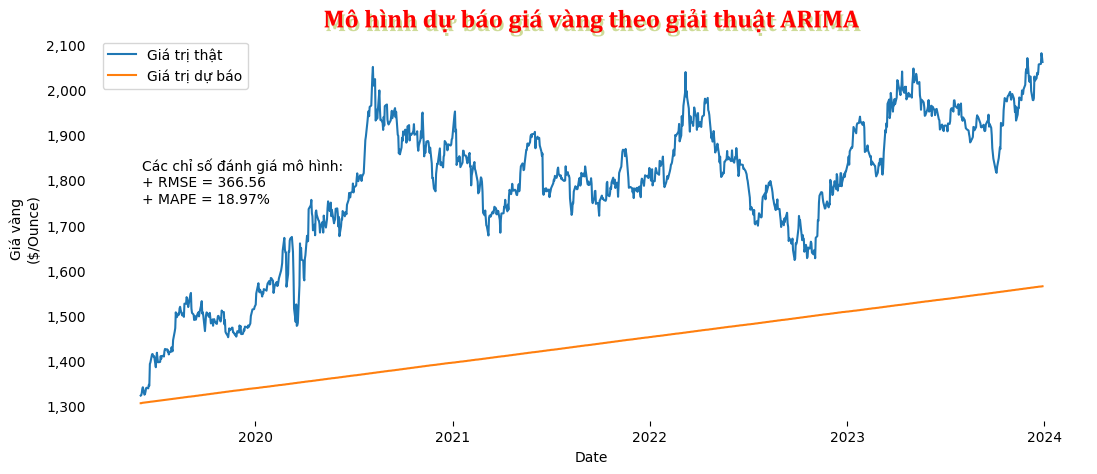

In [123]:
# Tạo tập test và tập train
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

# Xây dựng mô hình ARIMA
model_arima = ARIMA(train_data['close'], order=(2,2,6))
model_arima_fit = model_arima.fit()

# Tiến hành dự báo trên tập test
predictions = model_arima_fit.predict(start=len(train_data), end=len(df)-1, typ='levels')

# Vẽ chart
#   Định nghĩa size chart:
fig, ax = plt.subplots(figsize=(12.8, 5))

#   Đánh giá hiệu quả dự báo bằng MSE (mean squared error: sai số toàn phương trung bình)
#   và mape (Mean Absolute Percentage Error)
rmse = np.sqrt(mean_squared_error(test_data['close'], predictions))
mape = np.mean(np.abs((predictions - test_data['close']) / test_data['close'])) * 100

#   Vẽ chart để so sánh giá trị thực và giá trị dự báo
plt.plot(test_data['date'], test_data['close'], label='Giá trị thật')
plt.plot(test_data['date'], predictions, label='Giá trị dự báo')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Giá vàng\n($/Ounce)')
plt.title('Mô hình dự báo giá vàng theo giải thuật ARIMA', fontdict=title_font).set_path_effects([pe])

#   Thêm RMSE và MAPE vào chart
plt.text(test_data['date'].iloc[2], 1750, f"Các chỉ số đánh giá mô hình:\n+ RMSE = {rmse:,.2f}\n+ MAPE = {mape:,.2f}%", fontdict=label_font)

#   Format các giá trị trên trục tung
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

#   Xóa các đường khung
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')

#   Xóa các dấu tick trên trục tung
plt.gca().tick_params(left=False)
plt.gca().tick_params(left=False)

#   Hiển thị chart
plt.show()

In [124]:
# Dự báo giá vàng cho năm kế tiếp
forecast = model_arima_fit.forecast(steps=365)

forecast_df = pd.DataFrame({
    "date": pd.date_range(start=test_data['date'].iloc[-1], periods=365, freq='D'),
    "close": forecast
})

# Hiển thị kết quả
print(forecast_df)

           date        close
4616 2023-12-29  1305.811677
4617 2023-12-30  1305.774464
4618 2023-12-31  1306.324959
4619 2024-01-01  1306.635036
4620 2024-01-02  1306.770271
...         ...          ...
4976 2024-12-23  1386.771565
4977 2024-12-24  1386.996459
4978 2024-12-25  1387.220923
4979 2024-12-26  1387.445482
4980 2024-12-27  1387.670315

[365 rows x 2 columns]


## Áp dụng giải thuật Exponential smoothing

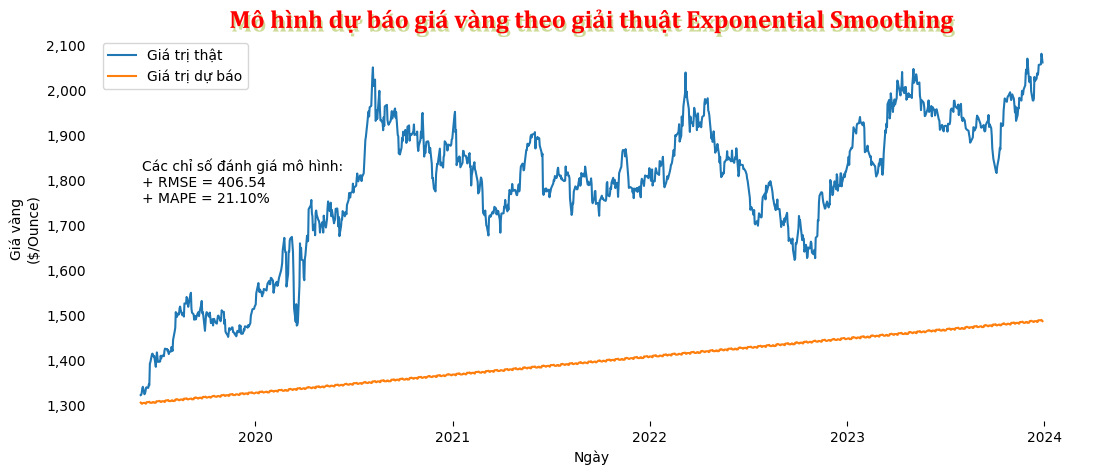

In [126]:
# import thư viện
from statsmodels.tsa.api import ExponentialSmoothing

# Xây dựng mô hình Exponential Smoothing
model_es = ExponentialSmoothing(train_data['close'], seasonal_periods=12, trend='add', seasonal='mul')
fit_model_es = model_es.fit()

# Tính toán biến dự báo
predictions1 = fit_model_es.forecast(len(test_data))

# Đánh giá giải thuật với 02 chỉ số: RMSE và MAPE
rmse1 = np.sqrt(mean_squared_error(test_data['close'], predictions1))
mape1 = np.mean(np.abs((predictions1 - test_data['close']) / test_data['close'])) * 100

# Vẽ chart
#   Định nghĩa size chart:
fig, ax = plt.subplots(figsize=(12.8, 5))

#   Thêm RMSE và MAPE vào chart
plt.text(test_data['date'].iloc[2], 1750, f"Các chỉ số đánh giá mô hình:\n+ RMSE = {rmse1:,.2f}\n+ MAPE = {mape1:,.2f}%", fontdict=label_font)

#   Thêm các label
plt.plot(test_data['date'], test_data['close'], label='Giá trị thật')
plt.plot(test_data['date'], predictions1, label='Giá trị dự báo')
plt.legend()
plt.xlabel('Ngày')
plt.ylabel('Giá vàng\n($/Ounce)')
plt.title('Mô hình dự báo giá vàng theo giải thuật Exponential Smoothing', fontdict=title_font).set_path_effects([pe])

#   Format các giá trị trên trục tung
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

#   Xóa các đường khung
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')

#   Xóa các dấu tick trên trục tung
plt.gca().tick_params(left=False)

#   Hiển thị chart
plt.show()

In [73]:
# Dự báo giá vàng cho năm kế tiếp
forecast1 = fit_model_es.forecast(steps=365)

forecast_df1 = pd.DataFrame({
    "date": pd.date_range(start=test_data['date'].iloc[-1], periods=365, freq='D'),
    "close": forecast
})

# Hiển thị kết quả
print(forecast_df1)

           date        close
4581 2023-06-29  1247.437468
4582 2023-06-30  1248.085903
4583 2023-07-01  1247.148384
4584 2023-07-02  1248.675878
4585 2023-07-03  1248.219542
...         ...          ...
4941 2024-06-23  1323.923134
4942 2024-06-24  1324.136387
4943 2024-06-25  1324.349019
4944 2024-06-26  1324.560063
4945 2024-06-27  1324.774082

[365 rows x 2 columns]


## Áp dụng giải thuật Prophet

In [127]:
# import thư viện prophet
from prophet import Prophet

# Đổi tên cột trong bộ dữ liệu theo đúng quy định của lib Prophet
df1 = df
df1 = df1.rename(columns={"date": "ds", "close": "y"})

# Tách bộ train và bộ test (20%)
train_size = int(len(df1) * 0.8)
train_data_prophet = df1[:train_size]
test_data_prophet = df1[train_size:]

# fit model
model_prophet = Prophet()
model_prophet.fit(train_data_prophet)

# Dự báo trên bộ test
predictions_prophet = model_prophet.predict(test_data_prophet[['ds']])

# Tính toán RMSE và MAPE
y_true = test_data_prophet['y']
y_pred = predictions_prophet['yhat']
rmse_prophet = mean_squared_error(y_true, y_pred, squared=False)
mape_prophet = mean_absolute_percentage_error(y_true, y_pred) * 100

14:34:51 - cmdstanpy - INFO - Chain [1] start processing
14:34:55 - cmdstanpy - INFO - Chain [1] done processing


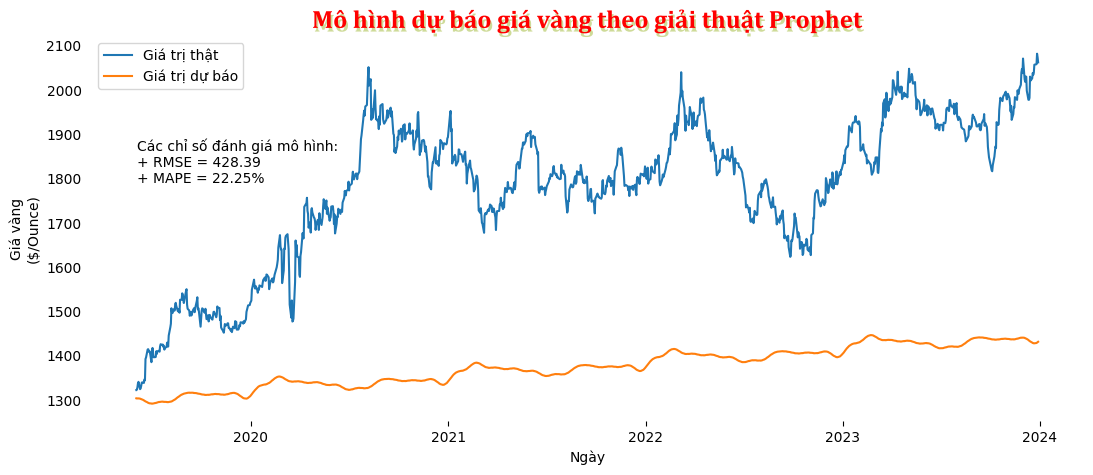

In [128]:
#Vẽ chart
fig, ax = plt.subplots(figsize=(12.8, 5))

plt.plot(test_data_prophet['ds'], test_data_prophet['y'], label='Giá trị thật')
plt.plot(test_data_prophet['ds'], y_pred, label='Giá trị dự báo')

#   Thêm các label
plt.xlabel('Ngày')
plt.ylabel('Giá vàng\n($/Ounce)')
plt.title('Mô hình dự báo giá vàng theo giải thuật Prophet', fontdict=title_font).set_path_effects([pe])
plt.text(test_data_prophet['ds'].iloc[1], 1790, f"Các chỉ số đánh giá mô hình:\n+ RMSE = {rmse_prophet:,.2f}\n+ MAPE = {mape_prophet:,.2f}%", fontdict=label_font)

#   Thêm legend
plt.legend()

#   Xóa các đường khung
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['left'].set_color('none')

#   Xóa các dấu tick trên trục tung
plt.tick_params(left=False)

# Hiển thị chart
plt.show()

In [78]:
# Dự báo cho 365 ngày kế:
future_dates = model_prophet.make_future_dataframe(periods=365)
future_predictions = model_prophet.predict(future_dates)
next_365_days = future_predictions[['ds', 'yhat']].tail(365).rename(columns={'ds': 'date', 'yhat': 'close'})
print(next_365_days)

           date        close
4581 2018-12-08  1290.016288
4582 2018-12-09  1289.296056
4583 2018-12-10  1282.167378
4584 2018-12-11  1281.008864
4585 2018-12-12  1280.381166
...         ...          ...
4941 2019-12-03  1317.071187
4942 2019-12-04  1317.024299
4943 2019-12-05  1316.304752
4944 2019-12-06  1316.158352
4945 2019-12-07  1322.085807

[365 rows x 2 columns]
